In [ ]:
from copy import deepcopy
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torch.utils.data.dataloader import DataLoader
from torchvision.ops import nms
from effdet import create_model, create_loader
from effdet.data import resolve_input_config, resolve_fill_color
from effdet.bench import DetBenchPredict  # noqa F401
from effdet.anchors import Anchors, AnchorLabeler
from effdet.data.transforms import ResizePad, ImageToNumpy, Compose
from timm.optim._optim_factory import create_optimizer_v2


from ml_carbucks.utils.result_saver import ResultSaver
from ml_carbucks.adapters.BaseDetectionAdapter import (
    BaseDetectionAdapter,
    ADAPTER_PREDICTION,
)
from ml_carbucks.utils.effdet_extension import (
    CocoStatsEvaluator,
    ConcatDetectionDataset,
    create_dataset_custom,
)
from ml_carbucks.utils.logger import setup_logger
from torchmetrics.detection.mean_ap import MeanAveragePrecision  # noqa: F401

from ml_carbucks import DATA_DIR, RESULTS_DIR
from ml_carbucks.utils.inference import plot_img_pred as ppp  # noqa: F401
from ml_carbucks.utils.preprocessing import create_clean_loader  # noqa: F401


logger = setup_logger(__name__)


@dataclass
class EfficientDetAdapter(BaseDetectionAdapter):


    weights: str | Path = ""
    backbone: str = "tf_efficientdet_d0"
    bench_labeler: bool = True

    optimizer: str = "momentum"
    lr: float = 8e-3
    weight_decay: float = 5e-5
    confidence_threshold: float = 0.2

    def save(self, dir: Path | str, prefix: str = "", suffix: str = "") -> Path:
        save_path = Path(dir) / f"{prefix}model{suffix}.pth"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(self.model.model.state_dict(), save_path)
        return save_path

    def clone(self) -> "EfficientDetAdapter":
        return EfficientDetAdapter(
            classes=deepcopy(self.classes),
            weights=self.weights,
            img_size=self.img_size,
            batch_size=self.batch_size,
            epochs=self.epochs,
            backbone=self.backbone,
            bench_labeler=self.bench_labeler,
            optimizer=self.optimizer,
            lr=self.lr,
            weight_decay=self.weight_decay,
        )

    def _predict_preprocess_images_v2(self, images: List[torch.Tensor]):
        input_config = resolve_input_config(self.get_params(), self.model.config)
        fill_color = resolve_fill_color(
            input_config["fill_color"], input_config["mean"]
        )
        transform = Compose(
            [
                ResizePad(
                    target_size=self.img_size,
                    interpolation=input_config["interpolation"],
                    fill_color=fill_color,
                ),
                ImageToNumpy(),
            ]
        )

        batch_list = []
        img_scaled = []

        for img in images:
            if isinstance(img, torch.Tensor):
                img = img.permute(1, 2, 0).cpu().numpy()  # [H,W,C]
            img_pil = Image.fromarray(img.astype(np.uint8))
            img_proc, anno = transform(img_pil, dict())  # no annotations
            batch_list.append(img_proc)
            img_scaled.append(anno.get("img_scale", 1.0))

        batch_np = np.stack(batch_list, axis=0)  # [B,C,H,W]
        batch_tensor = torch.from_numpy(batch_np).float().to(self.device)

        return batch_tensor, img_scaled

    # def predict(
    #     self,
    #     images: List[torch.Tensor],
    #     conf_threshold: float = 0.25,
    #     iou_threshold: float = 0.45,
    #     max_detections: int = 100,
    # ) -> List[ADAPTER_PREDICTION]:

    #     # NOTE: Something is wrong PROBABLY HERE, it needs to be verified more
    #     """
    #     The issue is that predicitons are weird but the results of the evaluation
    #     are good. So either the evaluation is wrong or the prediction extraction is wrong.
    #     """
    #     predictor = DetBenchPredict(deepcopy(self.model.model))
    #     predictor.to(self.device)
    #     predictor.eval()
    #     predictions: List[ADAPTER_PREDICTION] = []

    #     with torch.no_grad():
    #         batch_tensor, batch_scales = self._predict_preprocess_images_v2(images)
    #         outputs = predictor(batch_tensor)

    #         for i, pred in enumerate(outputs):
    #             out = pred.cpu()  # move to CPU
    #             boxes = out[:, :4]
    #             scores = out[:, 4]
    #             labels_idx = out[:, 5].long()

    #             # filter by confidence
    #             mask = scores >= conf_threshold
    #             boxes, scores, labels_idx = boxes[mask], scores[mask], labels_idx[mask]

    #             # apply NMS per image
    #             keep = nms(boxes, scores, iou_threshold)
    #             keep = keep[:max_detections]  # take top-k

    #             boxes = boxes[keep].numpy().copy()
    #             boxes *= batch_scales[i]

    #             scores = scores[keep].numpy()
    #             labels = [self.classes[idx - 1] for idx in labels_idx[keep]]

    #             predictions.append({"boxes": boxes, "scores": scores, "labels": labels})

    #     return predictions

    def predict(
        self,
        images: List[torch.Tensor],
        conf_threshold: float = 0.25,
        iou_threshold: float = 0.45,
        max_detections: int = 100,
    ) -> List[ADAPTER_PREDICTION]:
        """
        The issue is that predicitons are weird but the results of the evaluation
        are good. So either the evaluation is wrong or the prediction extraction is wrong.
        """
        predictor = DetBenchPredict(deepcopy(self.model.model))
        predictor.to(self.device)
        predictor.eval()
        predictions: List[ADAPTER_PREDICTION] = []

        with torch.no_grad():
            img_sizes = torch.tensor(
                [[img.shape[1], img.shape[2]] for img in images], dtype=torch.float32
            ).to(self.device)

            batch_tensor, batch_scales = self._predict_preprocess_images_v2(images)

            img_scales = torch.tensor(batch_scales, dtype=torch.float32).to(self.device)
            img_info_dict = {
                "img_scale": img_scales,
                "img_size": img_sizes,
            }

            outputs = predictor(batch_tensor, img_info=img_info_dict)

            for i, pred in enumerate(outputs):
                mask = pred[:, 4] >= conf_threshold
                if mask.sum() == 0:
                    boxes = np.zeros((0, 4), dtype=np.float32)
                    scores = np.zeros((0,), dtype=np.float32)
                    labels = []
                else:
                    boxes = pred[mask, :4]
                    scores = pred[mask, 4]
                    labels_idx = pred[mask, 5].long()

                    # apply NMS per image
                    keep = nms(boxes, scores, iou_threshold)
                    keep = keep[:max_detections]  # take top-k

                    boxes = boxes[keep].cpu().numpy().copy()

                    scores = scores[keep].cpu().numpy()
                    labels = [self.classes[idx - 1] for idx in labels_idx[keep]]
                predictions.append({"boxes": boxes, "scores": scores, "labels": labels})

        return predictions

    def setup(self) -> "EfficientDetAdapter":
        img_size = self.img_size

        backbone = self.backbone
        weights = self.weights
        bench_labeler = self.bench_labeler

        # NOTE: img size would need to be updated here if we want to change it
        # I dont think it is possible to change it after model creation
        extra_args = dict(image_size=(img_size, img_size))
        self.model = create_model(
            model_name=backbone,
            bench_task="train",
            num_classes=len(self.classes),
            pretrained=weights == "",
            checkpoint_path=str(weights),
            bench_labeler=bench_labeler,
            checkpoint_ema=False,
            **extra_args,
        )

        self.model.to(self.device)

        self.labeler = None
        if bench_labeler is False:
            self.labeler = AnchorLabeler(
                Anchors.from_config(self.model.config),
                self.model.config.num_classes,
                match_threshold=0.5,
            )

        return self

    def fit(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> "EfficientDetAdapter":
        logger.info("Starting training...")
        self.model.train()

        epochs = self.epochs
        opt = self.optimizer
        lr = self.lr
        weight_decay = self.weight_decay

        train_loader = self._create_loader(datasets, is_training=True)

        parser_max_label = train_loader.dataset.parsers[0].max_label  # type: ignore
        config_num_classes = self.model.config.num_classes

        if parser_max_label != config_num_classes:
            raise ValueError(
                f"Number of classes in dataset ({parser_max_label}) does not match "
                f"model config ({config_num_classes})."
                f"Please verify that the dataset is curated (classes IDs start from 1)"
            )

        optimizer = create_optimizer_v2(
            self.model,
            opt=opt,
            lr=lr,
            weight_decay=weight_decay,
        )

        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            _ = self.train_epoch(optimizer, train_loader)  # type: ignore

        return self

    def _create_loader(
        self, datasets: List[Tuple[str | Path, str | Path]], is_training: bool
    ):
        batch_size = self.batch_size

        all_datasets = []
        for img_dir, ann_file in datasets:
            dataset = create_dataset_custom(
                img_dir=img_dir,
                ann_file=ann_file,
                has_labels=True,
            )
            all_datasets.append(dataset)

        concat_dataset = ConcatDetectionDataset(all_datasets)

        input_config = resolve_input_config(self.get_params(), self.model.config)
        loader = create_loader(
            concat_dataset,
            input_size=input_config["input_size"],
            batch_size=batch_size,
            is_training=is_training,
            use_prefetcher=True,
            interpolation=input_config["interpolation"],
            fill_color=input_config["fill_color"],
            mean=input_config["mean"],
            std=input_config["std"],
            num_workers=4,
            distributed=False,
            pin_mem=False,
            anchor_labeler=self.labeler,
            transform_fn=None,
            collate_fn=None,
        )

        return loader

    def train_epoch(
        self, optimizer: torch.optim.Optimizer, loader: DataLoader
    ) -> float:
        self.model.train()

        total_loss = 0.0
        for imgs, targets in tqdm(loader):
            output = self.model(imgs, targets)
            loss = output["loss"]
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return total_loss

    def debug(
        self,
        train_datasets: List[Tuple[str | Path, str | Path]],
        val_datasets: List[Tuple[str | Path, str | Path]],
        results_path: str | Path,
        results_name: str,
    ) -> Dict[str, float]:
        logger.info("Debugging training and evaluation loops...")

        epochs = self.epochs
        train_loader = self._create_loader(train_datasets, is_training=True)
        optimizer = create_optimizer_v2(
            self.model,
            opt=self.optimizer,
            lr=self.lr,
            weight_decay=self.weight_decay,
        )
        saver = ResultSaver(
            path=results_path,
            name=results_name,
        )
        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            total_loss = self.train_epoch(optimizer, train_loader)  # type: ignore
            val_metrics = self.evaluate(val_datasets)
            saver.save(
                epoch=epoch,
                loss=total_loss,
                val_map=val_metrics["map_50_95"],
                val_map_50=val_metrics["map_50"],
            )
            logger.info(
                f"Debug Epoch {epoch}/{epochs} - Loss: {total_loss}, Val MAP: {val_metrics['map_50_95']}"
            )
            saver.plot(show=False)

        return val_metrics  # type: ignore

            
    def evaluate(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> Dict[str, float]:
        self.model.eval()

        val_loader = self._create_loader(datasets, is_training=False)

        evaluator = CocoStatsEvaluator(val_loader.dataset)
        total_loss = 0.0
        cnt = 10
        metric = MeanAveragePrecision(extended_summary=False, class_metrics=False)
        predictor = DetBenchPredict(deepcopy(self.model.model))
        predictor.to(self.device)
        predictor.eval()
        with torch.no_grad():
            for imgs, targets in val_loader:
                output = self.model(imgs, targets)
                pred_output = predictor(imgs)


                loss = output["loss"]
                total_loss += loss.item()

                evaluator.add_predictions(output["detections"], targets)
                figsize = (4,4)

                for i in range(len(imgs)):
                    cnt -= 1
                    # print(targets)

                    scale = targets["img_scale"][i] if "img_scale" in targets else 1.0
                    print()

                    pred_mask = pred_output[i][:, 4] > self.confidence_threshold
                    if pred_mask.sum() == 0:
                        pred_bbox = torch.zeros((0, 4), device=self.device)
                        pred_scores = torch.zeros((0,), device=self.device)
                    else:
                        pred_bbox = pred_output[i][pred_mask, :4]
                        pred_scores = pred_output[i][pred_mask, 4]

                    mask = output["detections"][i][:, 4] > self.confidence_threshold
                    if mask.sum() == 0:
                        bbox = torch.zeros((0, 4), device=self.device)
                        scores = torch.zeros((0,), device=self.device)
                        labels_idx = torch.zeros((0,), dtype=torch.long, device=self.device)
                    else:
                        bbox = output["detections"][i][mask, :4] 
                        scores = output["detections"][i][mask, 4]
                        labels_idx = output["detections"][i][mask, 5].long()

                    gt_mask = targets["cls"][i] > 0
                    if gt_mask.sum() == 0:
                        gt_bbox = torch.zeros((0, 4), device=self.device)
                        gt_labels_idx = torch.zeros((0,), dtype=torch.long, device=self.device)
                    else:
                        gt_bbox_yxyx = targets["bbox"][i][gt_mask] * scale
                        gt_bbox_xyxy = torch.zeros_like(gt_bbox_yxyx)
                        gt_bbox_xyxy[:, 0] = gt_bbox_yxyx[:, 1]
                        gt_bbox_xyxy[:, 1] = gt_bbox_yxyx[:, 0]
                        gt_bbox_xyxy[:, 2] = gt_bbox_yxyx[:, 3]
                        gt_bbox_xyxy[:, 3] = gt_bbox_yxyx[:, 2]
                        gt_bbox = gt_bbox_xyxy
                        gt_labels_idx = targets["cls"][i][gt_mask].long()

                    if cnt >= 0:
                        mask = output["detections"][i][:, 4] > 0.3
                        if mask.sum() == 0:
                            continue
                        
                        ppp(imgs[i], gt_bbox/scale, coords="xyxy", color="green", figsize=figsize)
                        ppp(imgs[i], bbox/scale, coords="xyxy", color="cyan", figsize=figsize)
                        ppp(imgs[i], pred_bbox, coords="xyxy", color="magenta", figsize=figsize)

                    metric.update(
                        [
                            {
                                "boxes": bbox,
                                "scores": scores,
                                "labels": labels_idx,
                            }
                        ],
                        [
                            {
                                "boxes": gt_bbox,
                                "labels": gt_labels_idx,
                            }
                        ],
                    )
                raise ValueError("stop")
                    # h, w = imgs.shape[2:]
                    # print("img size:", (w, h))
                    # print("bbox range:", bbox.min().item() if bbox.numel() else 0, bbox.max().item() if bbox.numel() else 0)
                    # print("gt range:", gt_bbox.min().item() if gt_bbox.numel() else 0, gt_bbox.max().item() if gt_bbox.numel() else 0)

                #     print(f"bbox: {bbox}, scores: {scores}, labels: {labels_idx}, gt_bbox: {gt_bbox}, gt_labels: {gt_labels_idx}")
                # print(evaluator.evaluate())
                # print("----")
                # print("Intermediate MAP:", metric.compute())
                # raise ValueError("stop")

        print(targets)
        mresults = metric.compute()
        print("Metric results:", mresults)
        print("Metric keys:", mresults.keys())
        results = evaluator.evaluate()
        metrics = {
            "map_50": results[1],
            "map_50_95": results[0],
        }
        return metrics

train_datasets = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "train",
        DATA_DIR / "car_dd_testing" / "instances_train_curated.json",
    )
]
val_datasets = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "val",
        DATA_DIR / "car_dd_testing" / "instances_val_curated.json",
    )
]
demo_datasets = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "val",
        DATA_DIR / "car_dd_testing" / "instances_demo_curated.json",
    )
]
emodel = EfficientDetAdapter(
    classes=["scratch", "dent", "crack"],
    **{
        "img_size": 384,
        "batch_size": 8,
        "epochs": 6,
        "optimizer": "momentum",
        "lr": 0.003459928723120903,
        "weight_decay": 0.0001302610542371722,
    },
    weights="/home/bachelor/ml-carbucks/results/debug/efficientdet/model.pth"
)




emodel.setup()

# --- TRAINING ---
# emodel.fit(train_datasets) # type: ignore
# save_path = emodel.save(RESULTS_DIR / "debug" / "efficientdet")

# --- EVALUATION ---
eres = emodel.evaluate(demo_datasets) # type: ignore
# print(eres)



# loader = create_clean_loader(val_datasets, shuffle=False, transforms=None, batch_size=8)  # type: ignore
# evaluator = MeanAveragePrecision()
# cnt2 = 5
# for batch in loader:
#     images, targets = batch
#     outputs = emodel.predict(images)

#     for i in range(len(images)):
#         cnt2 -= 1
#         if cnt2 >= 0:
#             ppp(images[i], targets[i]['boxes'], coords="xyxy", color="green", figsize=(4,4))
#             ppp(images[i], outputs[i]['boxes'], coords="xyxy", color="red", figsize=(4,4))
#             # print(targets)
#         else:
#             break
 


In [ ]:
def ppi1(images: List[torch.Tensor], img_size, config, hparams, device="cuda"): 
    input_config = resolve_input_config(hparams, config) 
    fill_color = resolve_fill_color( input_config["fill_color"], input_config["mean"] ) 
    mean = torch.tensor([x * 255 for x in input_config['mean']]).to(device).view( 3, 1, 1) 
    std = torch.tensor([x * 255 for x in input_config['std']]).to(device).view( 3, 1, 1) 
    transform = Compose( [ ResizePad( target_size=img_size, interpolation=input_config["interpolation"], fill_color=fill_color, ), ImageToNumpy(), ] ) 
    batch_list = [] 
    img_scaled = [] 
    for img in images: 
        img_pil = Image.fromarray(img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)) 
        img_proc, anno = transform(img_pil, dict()) # no annotations 
        img_norm = torch.from_numpy(img_proc).float().to(device).sub_(mean).div_(std) 
        batch_list.append(img_norm) 
        img_scaled.append(anno.get("img_scale", 1.0)) 
    batch_tensor = torch.stack(batch_list, dim=0).to(device) 
    img_scaled_tensor = torch.tensor(img_scaled, dtype=torch.float32).to(device) 
    
    return batch_tensor, img_scaled_tensor

def ppi2(images: List[torch.Tensor], img_size, config, hparams, device="cuda"):
        input_config = resolve_input_config(hparams,  config)
        fill_color = resolve_fill_color(
            input_config["fill_color"], input_config["mean"]
        )

        mean = (
            torch.tensor(input_config["mean"], device= device).view(3, 1, 1) * 255
        )
        std = torch.tensor(input_config["std"], device= device).view(3, 1, 1) * 255

        transform = Compose(
            [
                ResizePad(
                    target_size=img_size,
                    interpolation=input_config["interpolation"],
                    fill_color=fill_color,
                ),
                ImageToNumpy(),
            ]
        )

        batch, scales = [], []

        for img in images:

            img_np, anno = transform(
                Image.fromarray(img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)), {}
            )
            scales.append(anno.get("img_scale", 1.0))

            img_norm = (
                torch.from_numpy(img_np)
                .to( device, non_blocking=True)
                .float()
                .sub_(mean)
                .div_(std)
            )
            batch.append(img_norm)

        batch_tensor = torch.stack(batch, dim=0)  # B,C,H,W
        scales_tensor = torch.tensor(scales, dtype=torch.float32, device= device)

        return batch_tensor, scales_tensor

import time
import torch.nn.functional as F
from typing import Tuple

# NOTE: This function is fast but does not inherently follow exactly the same logic as effdet's ResizePad
# So it could be nice to use but in case of any further development it will need to be rewritten
def ppi_fast_torch(images: List[torch.Tensor], img_size: Tuple[int,int], config, hparams, device="cuda"):
    """
    Fast preprocessing when `images` are torch.Tensor (C,H,W) or (H,W,C).
    - images: list of torch.Tensor, expected [C,H,W] or [H,W,C] (will detect)
    - img_size: (H_target, W_target) or int -> square
    Returns: (batch_tensor [B,C,Ht,Wt], img_scales tensor [B])
    """
    # ensure img_size is (H,W)
    if isinstance(img_size, int):
        target_h = target_w = img_size
    else:
        target_h, target_w = img_size

    input_config = resolve_input_config(hparams, config)
    mean = torch.tensor([x * 255 for x in input_config['mean']], dtype=torch.float32, device=device).view(3,1,1)
    std  = torch.tensor([x * 255 for x in input_config['std']], dtype=torch.float32, device=device).view(3,1,1)

    # Normalize and pad/resize in-batch
    batch = []
    scales = []
    for img in images:
        # If image is H,W,C -> convert to C,H,W
        if img.ndim == 3 and img.shape[0] not in (1,3):
            img = img.permute(2,0,1)
        # Convert ints to float tensor in [0,255] if needed
        if img.dtype != torch.float32:
            img = img.to(dtype=torch.float32)
        # compute scale to fit while preserving aspect ratio (ResizePad behaviour)
        _, h, w = img.shape
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)
        # resize using interpolate: needs NCHW, so unsqueeze
        img_resized = F.interpolate(img.unsqueeze(0), size=(new_h, new_w), mode='bilinear', align_corners=False)[0]
        # pad to target size: anchor at top-left (no centering)
        pad_h = target_h - new_h
        pad_w = target_w - new_w
        # Top-left anchor: pad on right and bottom only
        pad_left = 0
        pad_right = pad_w
        pad_top = 0
        pad_bottom = pad_h

        # Fill/pad handling: ResizePad in effdet may accept RGB tuples or strings
        fill_val = input_config.get('fill_color', 0)
        # Normalize fill_val to either a scalar or a 3-tuple of ints
        if isinstance(fill_val, str):
            fv = fill_val.lstrip('#')
            if len(fv) == 6:
                try:
                    r = int(fv[0:2], 16)
                    g = int(fv[2:4], 16)
                    b = int(fv[4:6], 16)
                    fill_tuple = (r, g, b)
                except Exception:
                    fill_tuple = (0, 0, 0)
            else:
                # try comma-separated numbers
                try:
                    parts = [int(x) for x in fill_val.replace('(', '').replace(')', '').split(',')]
                    fill_tuple = tuple(parts)
                except Exception:
                    fill_tuple = (0, 0, 0)
        elif isinstance(fill_val, (list, tuple)):
            fill_tuple = tuple(fill_val)
        else:
            fill_tuple = float(fill_val)

        # If fill_tuple is per-channel, create a canvas and paste the resized image into top-left corner
        if isinstance(fill_tuple, tuple) and len(fill_tuple) >= img_resized.shape[0]:
            # create canvas with same dtype/device as img_resized
            canvas = img_resized.new_full((img_resized.shape[0], target_h, target_w), 0)
            for c in range(img_resized.shape[0]):
                canvas[c].fill_(float(fill_tuple[c]))
            # place at top-left
            canvas[:, 0 : new_h, 0 : new_w] = img_resized
            img_padded = canvas
        else:
            # scalar fill: use F.pad (top-left anchor achieved by padding right/bottom only)
            scalar_fill = float(fill_tuple)
            img_padded = F.pad(
                img_resized, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=scalar_fill
            )

        batch.append(img_padded)
        scales.append(scale)

    batch_tensor = torch.stack(batch, dim=0).to(device, non_blocking=True)  # B,C,H,W on device
    # normalize in-place
    batch_tensor = batch_tensor.sub_(mean).div_(std)

    img_scales = torch.tensor(scales, dtype=torch.float32, device=device)
    return batch_tensor, 1/img_scales


eloader = create_clean_loader(demo_datasets, shuffle=False, transforms=None, batch_size=2)  # type: ignore
images, targets = next(iter(eloader))

s = time.time()
batch_images0, batch_scales0 = ppi1(images, emodel.img_size, emodel.model.config, emodel.get_params())
e = time.time()
print("PPI1 time:", e - s)
s = time.time()
batch_images, batch_scales = ppi2(images, emodel.img_size, emodel.model.config, emodel.get_params())
e = time.time()
print("PPI2 time:", e - s)

s = time.time()
batch_images_fast, batch_scales_fast = ppi_fast_torch(images, (emodel.img_size,emodel.img_size), emodel.model.config, emodel.get_params())
e = time.time()
print("PPI Fast time:", e - s)
print(batch_images_fast.shape, batch_scales_fast)
iii = 0
ppp(images[iii], targets[iii]['boxes'], coords="xyxy", color="green", figsize=(4,4))
ppp(batch_images[iii], targets[iii]['boxes']/batch_scales[iii].cpu(), coords="xyxy", color="green", figsize=(4,4))
ppp(batch_images_fast[iii], targets[iii]['boxes']/batch_scales_fast[iii].cpu(), coords="xyxy", color="green", figsize=(4,4))

"""
PPI2 time: 0.0068073272705078125
PPI Fast time: 0.0015950202941894531
"""

In [ ]:
from ml_carbucks.adapters.EfficientDetAdapter import EfficientDetAdapter as EfficientDetAdapterOrg
from ml_carbucks.utils.preprocessing import create_clean_loader  # noqa: F401
from ml_carbucks import DATA_DIR
from ml_carbucks.utils.inference import plot_img_pred as ppp  # noqa: F401

demo_datasets = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "val",
        DATA_DIR / "car_dd_testing" / "instances_demo_curated.json",
    )
]
eloader = create_clean_loader(demo_datasets, shuffle=False, transforms=None, batch_size=2)  # type: ignore
images, targets = next(iter(eloader))

eee = EfficientDetAdapterOrg(
classes=["scratch", "dent", "crack"],
    **{
        "img_size": 384,
        "batch_size": 8,
        "epochs": 6,
        "optimizer": "momentum",
        "lr": 0.003459928723120903,
        "weight_decay": 0.0001302610542371722,
    },
    weights="/home/bachelor/ml-carbucks/results/debug/efficientdet/model.pth"
)
eee.setup()

# model_train = deepcopy(eee.model).eval().to("cuda")
# model_predict = DetBenchPredict(deepcopy(eee.model.model)).eval().to("cuda")


preds = eee.predict(images, conf_threshold=0.2, iou_threshold=0.4)

ppp(images[0], preds[0]['boxes'], coords="xyxy", color="red", figsize=(4,4))

# img_batch, img_scales = ppi2(images, eee.img_size, eee.model.config, eee.get_params())


# img_sizes = torch.tensor(
#     [[img.shape[1], img.shape[2]] for img in images], dtype=torch.float32
# ).to("cuda")

# img_info_dict = {
#     "img_scale": img_scales,
#     "img_size": img_sizes,
# }
# print(eee.img_size)
# print(img_info_dict)
# print(targets)
# targets_empty = {
#     **{
#         "img_size": img_sizes,
#         "img_scale": img_scales,
#     },
#     "bbox": torch.zeros((0, 4), dtype=torch.float32).to("cuda"),
#     "cls": torch.zeros((0,), dtype=torch.int64).to("cuda"),
# }
# with torch.no_grad():
#     out_train = model_train(img_batch, targets)  # DetBenchTrain; produces output["detections"]
#     # out_pred = model_predict(img_batch, img_info=img_info_dict)  # DetBenchPredict -> list[tensor]


# THIS HERE IS THE FIXXING OF PREDICTION DATA LOADING AND PRE AND POST PROCESSING

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
INFO __main__ 20:05:26 | THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK DURING EVALUAITON
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


torch.Size([3, 384, 384])


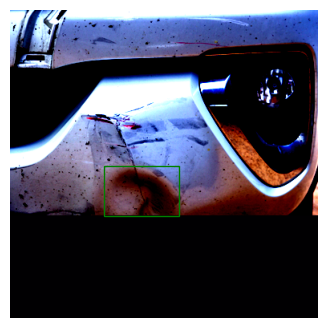

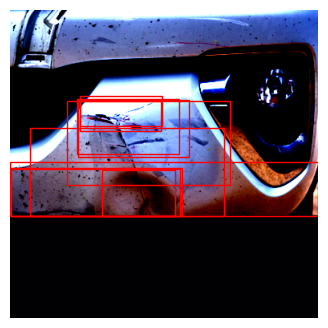

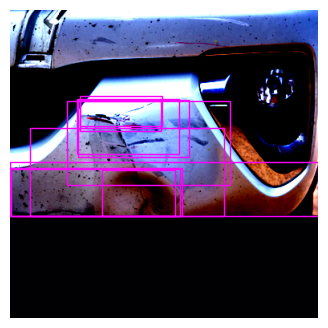

(667, 1000, 3)
INFO __main__ 20:05:27 | THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK DURING PREDICTION


PREPROCESSING: image shape: (667, 1000, 3) -> batch shape: torch.Size([3, 384, 384])
Prediction 0 - scale: 2.6041667461395264


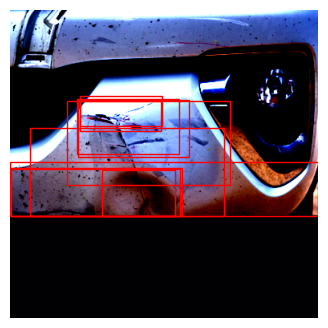

INFO __main__ 20:05:27 | THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK POSTPROCESSED


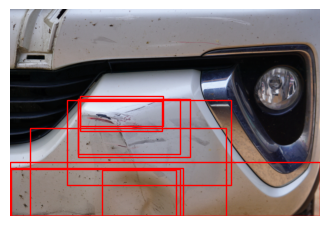

In [6]:
from copy import deepcopy
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torch.utils.data.dataloader import DataLoader
from torchvision.ops import nms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from effdet import create_model, create_loader
from effdet.data import resolve_input_config, resolve_fill_color
from effdet.bench import DetBenchPredict  # noqa F401
from effdet.data.transforms import ResizePad, ImageToNumpy, Compose
from timm.optim._optim_factory import create_optimizer_v2

from ml_carbucks.utils.postprocessing import postprocess_prediction
from ml_carbucks.utils.result_saver import ResultSaver
from ml_carbucks.adapters.BaseDetectionAdapter import (
    BaseDetectionAdapter,
    ADAPTER_PREDICTION,
)
from ml_carbucks.utils.effdet_extension import (
    CocoStatsEvaluator,
    ConcatDetectionDataset,
    create_dataset_custom,
)
from ml_carbucks.utils.logger import setup_logger
from ml_carbucks import DATA_DIR
from ml_carbucks.utils.preprocessing import create_clean_loader, simple_transform  # noqa: F401
from ml_carbucks.utils.inference import plot_img_pred as ppp  # noqa: F401

logger = setup_logger(__name__)


@dataclass
class EfficientDetAdapter(BaseDetectionAdapter):

    weights: str | Path = ""
    backbone: str = "tf_efficientdet_d0"

    optimizer: str = "momentum"
    lr: float = 8e-3
    weight_decay: float = 9e-6
    confidence_threshold: float = 0.15
    training_augmentations: bool = True

    def save(self, dir: Path | str, prefix: str = "", suffix: str = "") -> Path:
        save_path = Path(dir) / f"{prefix}model{suffix}.pth"
        save_path.parent.mkdir(parents=True, exist_ok=True)
        torch.save(self.model.model.state_dict(), save_path)
        return save_path

    def _preprocess_images(
        self, images: List[np.ndarray]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        input_config = resolve_input_config(self.get_params(), self.model.config)
        fill_color = resolve_fill_color(
            input_config["fill_color"], input_config["mean"]
        )

        mean = (
            torch.tensor(input_config["mean"], device=self.device).view(3, 1, 1) * 255
        )
        std = torch.tensor(input_config["std"], device=self.device).view(3, 1, 1) * 255

        transform = Compose(
            [
                ResizePad(
                    target_size=self.img_size,
                    interpolation=input_config["interpolation"],
                    fill_color=fill_color,
                ),
                ImageToNumpy(),
            ]
        )

        batch, scales = [], []

        for img in images:

            img_np, anno = transform(
                Image.fromarray(img), {}
            )
            scales.append(anno.get("img_scale", 1.0))

            img_norm = (
                torch.from_numpy(img_np)
                .to(self.device, non_blocking=True)
                .float()
                .sub_(mean)
                .div_(std)
            )
            batch.append(img_norm)

        print(f"PREPROCESSING: image shape: {images[0].shape} -> batch shape: {batch[0].shape}")
        batch_tensor = torch.stack(batch, dim=0)  # B,C,H,W
        scales_tensor = torch.tensor(scales, dtype=torch.float32, device=self.device)
        batch_original_sizes = torch.tensor(
            [[img.shape[1], img.shape[0]] for img in images], 
            dtype=torch.float32,
            device=self.device,
        )

        return batch_tensor, scales_tensor, batch_original_sizes

    def predict(
        self,
        images: List[np.ndarray],
        conf_threshold: float = -1.0,
        iou_threshold: float = -1.0,
        max_detections: int = 10,
    ) -> List[ADAPTER_PREDICTION]:
        """
        The issue is that predicitons are weird but the results of the evaluation
        are good. So either the evaluation is wrong or the prediction extraction is wrong.
        """
        predictor = DetBenchPredict(deepcopy(self.model.model))
        predictor.to(self.device)
        predictor.eval()
        predictions: List[ADAPTER_PREDICTION] = []

        with torch.no_grad():

            batch_tensor, batch_scales, batch_original_sizes = self._preprocess_images(
                images
            )

            img_info_dict = {
                "img_scale": batch_scales,
                "img_size": batch_original_sizes,
            }

            outputs = predictor(batch_tensor, img_info=img_info_dict)


            for i, pred in enumerate(outputs):
                if i == 0:
                    scale = batch_scales[i]
                    print(f"Prediction {i} - scale: {scale}")
                    # print(batch_tensor[i])
                    # pred_box = pred[:10, :4] / batch_scales[i]
                    pred_box = pred[:10, :4] / scale

                    # print(pred)
                    ppp(batch_tensor[i], pred_box, coords="xyxy", color="red", figsize=(4,4))
                boxes = pred[:, :4]
                scores = pred[:, 4]
                labels_idx = pred[:, 5]

                prediction = postprocess_prediction(
                    boxes,
                    scores,
                    labels_idx,
                    conf_threshold,
                    iou_threshold,
                    max_detections,
                )

                predictions.append(prediction)

        return predictions        

        # cnt = 1
        # with torch.no_grad():

        #     batch_tensor, batch_scales, batch_original_sizes = self._preprocess_images(
        #         images
        #     )

        #     print("Batch scales:", batch_scales)
        #     print("Batch original sizes:", batch_original_sizes)
        #     img_info_dict = {
        #         "img_scale": batch_scales,
        #         "img_size": batch_original_sizes,
        #     }
        #     outputs = predictor(batch_tensor, img_info=img_info_dict)

        #     # outputs = predictor(batch_tensor)

        #     for i, pred in enumerate(outputs):
        #         scale = batch_scales[i]
        #         print(f"Prediction {i} - scale: {scale}")
        #         # print(batch_tensor[i])
        #         # pred_box = pred[:10, :4] / batch_scales[i]
        #         pred_box = pred[:10, :4] / scale

        #         # print(pred)
        #         ppp(batch_tensor[i], pred_box, coords="xyxy", color="red", figsize=(4,4))
        #         cnt -= 1
        #         if cnt <= 0:
        #             break

            # for i, pred in enumerate(outputs):
            #     mask = pred[:, 4] >= conf_threshold
            #     if mask.sum() == 0:
            #         boxes = np.zeros((0, 4), dtype=np.float32)
            #         scores = np.zeros((0,), dtype=np.float32)
            #         labels = []
            #     else:
            #         boxes = pred[mask, :4]
            #         scores = pred[mask, 4]
            #         labels_idx = pred[mask, 5].long()

            #         # apply NMS per image
            #         keep = nms(boxes, scores, iou_threshold)
            #         keep = keep[:max_detections]  # take top-k

            #         boxes = boxes[keep].cpu().numpy().copy()

            #         scores = scores[keep].cpu().numpy()
            #         labels = [
            #             idx for idx in labels_idx[keep]
            #         ]  # Predictions are 1-indexed
            #     predictions.append({"boxes": boxes, "scores": scores, "labels": labels})

        # return predictions

    def setup(self) -> "EfficientDetAdapter":
        img_size = self.img_size

        backbone = self.backbone
        weights = self.weights

        extra_args = dict(image_size=(img_size, img_size))
        self.model = create_model(
            model_name=backbone,
            bench_task="train",
            num_classes=len(self.classes),
            pretrained=weights == "",
            checkpoint_path=str(weights),
            # NOTE: we set it to True because we are using custom Mean Average Precision and it is easier that way
            # custom anchor labeler would be good idea if the boxes had unusual sizes and aspect ratios -> worth remembering for future
            bench_labeler=True,
            checkpoint_ema=False,
            **extra_args,
        )

        self.model.to(self.device)

        return self

    def fit(
        self, datasets: List[Tuple[str | Path, str | Path]]
    ) -> "EfficientDetAdapter":
        logger.info("Starting training...")
        self.model.train()

        epochs = self.epochs
        opt = self.optimizer
        lr = self.lr
        weight_decay = self.weight_decay

        train_loader = self._create_loader(datasets, is_training=True)

        parser_max_label = train_loader.dataset.parsers[0].max_label  # type: ignore
        config_num_classes = self.model.config.num_classes

        if parser_max_label != config_num_classes:
            raise ValueError(
                f"Number of classes in dataset ({parser_max_label}) does not match "
                f"model config ({config_num_classes})."
                f"Please verify that the dataset is curated (classes IDs start from 1)"
            )

        optimizer = create_optimizer_v2(
            self.model,
            opt=opt,
            lr=lr,
            weight_decay=weight_decay,
        )

        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            _ = self.train_epoch(optimizer, train_loader)  # type: ignore

        return self

    def _create_loader(
        self, datasets: List[Tuple[str | Path, str | Path]], is_training: bool
    ):
        batch_size = self.batch_size

        all_datasets = []
        for img_dir, ann_file in datasets:
            dataset = create_dataset_custom(
                img_dir=img_dir,
                ann_file=ann_file,
                has_labels=True,
            )
            all_datasets.append(dataset)

        concat_dataset = ConcatDetectionDataset(all_datasets)

        if is_training and (not self.training_augmentations):
            logger.warning(
                "Data augmentations are disabled. This may worsen model performance. It should only be used for debugging purposes."
            )

        input_config = resolve_input_config(self.get_params(), self.model.config)
        loader = create_loader(
            concat_dataset,
            input_size=input_config["input_size"],
            batch_size=batch_size,
            is_training=is_training and self.training_augmentations,
            use_prefetcher=True,
            interpolation=input_config["interpolation"],
            fill_color=input_config["fill_color"],
            mean=input_config["mean"],
            std=input_config["std"],
            num_workers=4,
            distributed=False,
            pin_mem=False,
            anchor_labeler=None,
            transform_fn=None,
            collate_fn=None,
        )

        return loader

    def train_epoch(
        self, optimizer: torch.optim.Optimizer, loader: DataLoader
    ) -> float:
        self.model.train()

        total_loss = 0.0
        for imgs, targets in tqdm(loader):
            output = self.model(imgs, targets)
            loss = output["loss"]
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return total_loss

    def debug(
        self,
        train_datasets: List[Tuple[str | Path, str | Path]],
        val_datasets: List[Tuple[str | Path, str | Path]],
        results_path: str | Path,
        results_name: str,
    ) -> Dict[str, float]:
        logger.info("Debugging training and evaluation loops...")

        epochs = self.epochs
        train_loader = self._create_loader(train_datasets, is_training=True)
        optimizer = create_optimizer_v2(
            self.model,
            opt=self.optimizer,
            lr=self.lr,
            weight_decay=self.weight_decay,
        )
        saver = ResultSaver(
            path=results_path,
            name=results_name,
        )
        val_metrics = dict()
        for epoch in range(1, epochs + 1):
            logger.info(f"Epoch {epoch}/{epochs}")

            total_loss = self.train_epoch(optimizer, train_loader)  # type: ignore
            val_metrics = self.evaluate(val_datasets)
            saver.save(
                epoch=epoch,
                loss=total_loss,
                val_map=val_metrics["map_50_95"],
                val_map_50=val_metrics["map_50"],
            )
            logger.info(
                f"Debug Epoch {epoch}/{epochs} - Loss: {total_loss}, Val MAP: {val_metrics['map_50_95']}"
            )
            saver.plot(show=False)

        return val_metrics

    def evaluate(
        self,
        datasets: List[Tuple[str | Path, str | Path]],
        include_default: bool = False,
    ) -> Dict[str, float]:
        self.model.eval()

        predictor = DetBenchPredict(deepcopy(self.model.model))
        predictor.to(self.device)
        predictor.eval()        

        val_loader = self._create_loader(datasets, is_training=False)

        default_evaluator = None
        if include_default:
            default_evaluator = CocoStatsEvaluator(dataset=val_loader.dataset)

        evaluator = MeanAveragePrecision(extended_summary=False, class_metrics=False)
        total_loss = 0.0

        cnt = 1
        skip_cnt = 1
        skip = False
        with torch.no_grad():
            
            for imgs, targets in val_loader:
                if skip_cnt >0:
                    skip_cnt -=1
                    continue
                output = self.model(imgs, targets)
                loss = output["loss"]
                total_loss += loss.item()

                pred_output = predictor(imgs, targets)

                for i in range(len(output["detections"])):
                    scale = targets["img_scale"][i]
                    if cnt >0:
                        cnt -=1
                        print(imgs[i].shape)
                        gt_boxes_yxyx = targets['bbox'][i][:1]
                        gt_boxes_xyxy = torch.zeros_like(gt_boxes_yxyx)
                        gt_boxes_xyxy[:,0] = gt_boxes_yxyx[:,1]
                        gt_boxes_xyxy[:,1] = gt_boxes_yxyx[:,0]
                        gt_boxes_xyxy[:,2] = gt_boxes_yxyx[:,3]
                        gt_boxes_xyxy[:,3] = gt_boxes_yxyx[:,2]
                        gt_boxes_xyxy = gt_boxes_xyxy

                        # print(imgs[i])
                        ppp(imgs[i], gt_boxes_xyxy, coords="xyxy", color="green", figsize=(4,4))

                        demo_boxes_xyxy = output["detections"][i][:10,:4] / scale

                        ppp(imgs[i], demo_boxes_xyxy, coords="xyxy", color="red", figsize=(4,4))

                        pred_boxes_xyxy = pred_output[i][:10,:4] / scale
                        ppp(imgs[i], pred_boxes_xyxy, coords="xyxy", color="magenta", figsize=(4,4))
                    else: 
                        skip = True
                
                if skip:
                    break

                if include_default and default_evaluator is not None:
                    default_evaluator.add_predictions(
                        detections=output["detections"], target=targets
                    )

                # NOTE:
                # Annotations are loaded in yxyx format and they are scaled
                # Predicitons are in xyxy format and not scaled (original size of the image)
                # So we need to rescale the ground truth boxes to original sizes
                # Predicitons have a lot of low confidence scores and ground_truths have a lot of -1 values that just indicate no object
                # We need to filter them out
                for i in range(len(imgs)):
                    scale = targets["img_scale"][i]

                    pred_mask = (
                        output["detections"][i][:, 4] >= self.confidence_threshold
                    )
                    if pred_mask.sum() == 0:
                        # No predcitions above the confidence threshold
                        pred_boxes = torch.zeros((0, 4), dtype=torch.float32)
                        pred_scores = torch.zeros((0,), dtype=torch.float32)
                        pred_labels = torch.zeros((0,), dtype=torch.int64)
                    else:
                        pred_boxes = output["detections"][i][pred_mask, :4]
                        pred_scores = output["detections"][i][pred_mask, 4]
                        pred_labels = output["detections"][i][pred_mask, 5].long()

                    gt_mask = targets["cls"][i] != -1
                    if gt_mask.sum() == 0:
                        # No ground truth boxes
                        gt_boxes = torch.zeros((0, 4), dtype=torch.float32)
                        gt_labels = torch.zeros((0,), dtype=torch.int64)
                    else:
                        gt_boxes_yxyx_raw = targets["bbox"][i][gt_mask]
                        gt_boxes_xyxy = torch.zeros_like(gt_boxes_yxyx_raw)
                        gt_boxes_xyxy[:, 0] = gt_boxes_yxyx_raw[:, 1]
                        gt_boxes_xyxy[:, 1] = gt_boxes_yxyx_raw[:, 0]
                        gt_boxes_xyxy[:, 2] = gt_boxes_yxyx_raw[:, 3]
                        gt_boxes_xyxy[:, 3] = gt_boxes_yxyx_raw[:, 2]
                        gt_boxes = gt_boxes_xyxy * scale
                        gt_labels = targets["cls"][i][gt_mask].long()

                    evaluator.update(
                        preds=[
                            {
                                "boxes": pred_boxes.cpu(),
                                "scores": pred_scores.cpu(),
                                "labels": pred_labels.cpu(),
                            }
                        ],
                        target=[
                            {
                                "boxes": gt_boxes.cpu(),
                                "labels": gt_labels.cpu(),
                            }
                        ],
                    )

        results = evaluator.compute()
        metrics = {
            "map_50": results["map_50"].item(),
            "map_50_95": results["map"].item(),
        }
        if include_default and default_evaluator is not None:
            default_results = default_evaluator.evaluate()
            metrics.update(
                {
                    "default_map_50_95": default_results[0],
                    "default_map_50": default_results[1],
                }
            )

        return metrics


val_datasets : List[Tuple[str|Path, str|Path]] = [
    (
        DATA_DIR / "car_dd_testing" / "images" / "val",
        DATA_DIR / "car_dd_testing" / "instances_val_curated.json",
    )
]
loader = create_clean_loader(
    val_datasets, shuffle=False, transforms=None, batch_size=8 # type: ignore
)

adapter = EfficientDetAdapter(
    classes=["scratch", "dent", "crack"],
    **{
        "img_size": 384,
        "batch_size": 8,
        "epochs": 26,
        "optimizer": "momentum",
        "lr": 0.003459928723120903,
        "weight_decay": 0.0001302610542371722,
    },
    weights="/home/bachelor/ml-carbucks/results/ensemble_demos/trial_4_EfficientDetAdaptermodel.pth",
).setup()


logger.info("THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK DURING EVALUAITON")
res = adapter.evaluate(val_datasets)

skip_cnt = 1
for custom_batch in loader:
    if skip_cnt >0:
        skip_cnt -=1
        continue
    else:
        break
batch_img_nparray, batch_targets = custom_batch # type: ignore
print(batch_img_nparray[0].shape)
logger.info("THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK DURING PREDICTION")
pred = adapter.predict(batch_img_nparray)

iii = 0

logger.info("THIS IS PRINTING HOW THE IMAGE AND LABELS LOOK POSTPROCESSED")
ppp(
    torch.from_numpy(batch_img_nparray[iii]).permute(2, 0, 1),
    bboxes=pred[iii]["boxes"],
    coords="xyxy",
    figsize=(4, 4),
)

# loader_v2 = create_clean_loader(
#     val_datasets, shuffle=False, transforms=simple_transform(), batch_size=8 # type: ignore
# )
# skip_cnt2 = 1
# for custom_batch2 in loader_v2:
#     if skip_cnt2 >0:
#         skip_cnt2 -=1
#         continue
#     else:
#         break
# img2, targets2 = custom_batch2  # type: ignore


# ppp(
#     img2[0],
#     bboxes= [],
#     coords="xyxy",
#     figsize=(4,4),
# )
# print(img2[0].shape)
